In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'
import sys

sys.path.append('../')

import numpy as np
import sys
import scipy.ndimage as nd
import json
import pickle
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.transforms import Resize
from torch.utils.data import Dataset, DataLoader
from models.resnet import *
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import time
import math
from utils.utils import AverageMeter
from datasets.Preprocess_2D import Slice2D_DataPreprocess
from train.train_2d_cls2 import test

import torch.nn.functional as F

import scipy.ndimage as nd
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
config_file = '../config/config_2D.json'
with open(config_file,encoding='gb2312') as f:
    config = json.load(f)
config

{'train_list_file': '',
 'val_list_file': '',
 'test_list_file': '',
 'model_dir': '',
 'num_classes': 2,
 'phase': 'train',
 'model': 'resnet34',
 'weight': None,
 'lr': 0.001,
 'mom': 0.9,
 'wd': 0.0001,
 'fix': 50,
 'step': 20,
 'epoch': 120,
 'display': 100,
 'num_workers': 8,
 'batch_size': 12,
 'dim_z': 128,
 'dim_x': 128,
 'optimizer': 'sgd'}

In [3]:
batch_size = 4
num_workers = 4
phase = 'train'
epochs = 10000
display = 2
data_transforms = transforms.Compose([
#         transforms.Resize((512,512)),
        transforms.ToTensor(),
    ]) 

In [4]:
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(512, 2)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# data_type = 'phase1'
# weights = '../data/aug2D/slice_phase1_exp2/phase1_0.5981308411214953_2_Fattyliver.pth' #0.6358
# weights = '/home/zhangwd/code/work/FattyLiver_Solution/data/aug2D/slice_phase1_exp2/phase1_0.7102803738317757_23_Fattyliver.pth'#0.5906

# data_type = 'phase2'
# weights = '../data/aug2D/slice_phase2_exp2/phase2_0.5887850467289719_44_Fattyliver.pth'#0.5891

# data_type = 'diff'
# weights = '../data/aug2D/slice_diff_exp2/diff_0.6074766355140186_11_Fattyliver.pth' #0.5646

#after crop
data_type = 'phase1'
weights = '../data/aug2D/slice_crop_phase1_exp2/phase1_0.5981308411214953_39_Fattyliver.pth'#0.6858

# data_type = 'phase2'
# weights = '../data/aug2D/slice_crop_phase2_exp2/phase2_0.5981308411214953_47_Fattyliver.pth' #0.6038

# data_type = 'diff'
# weights = '../data/aug2D/slice_crop_diff_exp2/diff_0.616822429906542_53_Fattyliver.pth' #0.4651


model.load_state_dict(torch.load(weights))

<All keys matched successfully>

In [5]:
data_root = '/home/zhangwd/code/work/FattyLiver_Solution/data/experiment_slice/train/{}'.format(data_type)
config_test = '../data/config/config_train.txt'

test_ds = Slice2D_DataPreprocess(data_root, data_type, config_test, data_transforms)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, pin_memory=False)

====> fatty liver count is:747


In [6]:
criterion = nn.CrossEntropyLoss().cuda()
acc, logger, tot_pred, tot_label, tot_prob = test(test_dataloader, nn.DataParallel(model).cuda(), criterion, 0, 10)
print(acc)
print(tot_prob)

../train/train_2d_cls2.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  tot_prob = np.append(tot_prob, F.softmax(output).cpu().detach().numpy()[:,1])


Epoch: [0][9/187]	Time 0.032566 (0.941)	Data 0.040	Loss 0.6164	Accuray 0.7000
Epoch: [0][19/187]	Time 0.028118 (0.488)	Data 0.022	Loss 0.7467	Accuray 0.5750
Epoch: [0][29/187]	Time 0.054040 (0.341)	Data 0.019	Loss 0.7452	Accuray 0.5583
Epoch: [0][39/187]	Time 0.033301 (0.265)	Data 0.016	Loss 0.6944	Accuray 0.6188
Epoch: [0][49/187]	Time 0.070932 (0.223)	Data 0.016	Loss 0.6992	Accuray 0.6100
Epoch: [0][59/187]	Time 0.140571 (0.194)	Data 0.017	Loss 0.7649	Accuray 0.5583
Epoch: [0][69/187]	Time 0.035661 (0.172)	Data 0.015	Loss 0.7967	Accuray 0.5214
Epoch: [0][79/187]	Time 0.058057 (0.157)	Data 0.016	Loss 0.7682	Accuray 0.5469
Epoch: [0][89/187]	Time 0.031947 (0.144)	Data 0.014	Loss 0.7819	Accuray 0.5333
Epoch: [0][99/187]	Time 0.032707 (0.133)	Data 0.013	Loss 0.7338	Accuray 0.5800
Epoch: [0][109/187]	Time 0.060235 (0.125)	Data 0.013	Loss 0.6966	Accuray 0.6182
Epoch: [0][119/187]	Time 0.050797 (0.118)	Data 0.012	Loss 0.6945	Accuray 0.6208
Epoch: [0][129/187]	Time 0.035950 (0.111)	Data 0.01

In [7]:
def plot_roc(y_true, y_pred, class_name='dr'):
    print('\n====> plot {} info:\n'.format(class_name))
    log = []
    from sklearn import metrics
    def calc_metrics_table(y_true, y_pred, thresholds):
        metrics_list = list()
        for threshold in thresholds:
            y_pred_binary = np.zeros(y_pred.shape, dtype=np.uint8)
            y_pred_binary[y_pred>threshold] = 1
            tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_binary).ravel()
            print('tn:{:.3f}\tfp:{:.3f}\tfn:{:.3f}\ttp:{:.3f}\t'.format(tn, fp, fn, tp))
            accuracy = (tp+tn)/(tn+fp+fn+tp)
            sensitivity = tp/(tp+fn)
            specificity = tn/(fp+tn)
            ppv = tp/(tp+fp)
            npv = tn/(tn+fn)
            metrics_list.append([threshold, accuracy, sensitivity, specificity, ppv, npv])
        metrics_table = pd.DataFrame(np.array(metrics_list), columns=['threshold','accuracy','sensitivity','specificity','ppv','npv'])
        return metrics_table


    fpr, tpr, thres = metrics.roc_curve(y_true, y_pred)

    auc = metrics.auc(fpr, tpr)

    thresholds = np.arange(0.05, 1., 0.05)
    metrics_table = calc_metrics_table(y_true, y_pred, thresholds)

    print('\nAUC:%.4f\n'% auc)
    log.append('AUC:%.4f'% auc)

    plt.figure()
    plt.title('{} roc curve'.format(class_name))
    plt.plot(fpr, tpr, 'r')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.grid(ls='--')
    plt.show()

    print(metrics_table)
    log.append(metrics_table)
    return log


====> plot fatty liver classification 2 info:

tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:0.000	fp:330.000	fn:0.000	tp:417.000	
tn:7.000	fp:323.000	fn:2.000	tp:415.000	
tn:98.000	fp:232.000	fn:121.000	tp:296.000	
tn:237.000	fp:93.000	fn:296.000	tp:121.000	
tn:313.000	fp:17.000	fn:391.000	tp:26.000	
tn:326.000	fp:4.000	fn:409.000	tp:8.000	
tn:330.000	fp:0.000	fn:417.000	tp:0.000	
tn:330.000	fp:0.000	fn:417.000	tp:0.000	

AUC:0.5042



/home/zhangwd/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/zhangwd/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


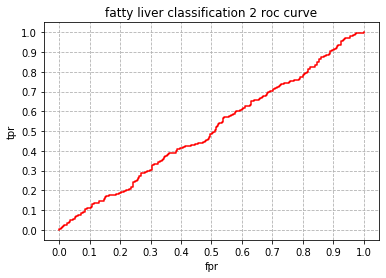

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.558233     1.000000     0.000000  0.558233       NaN
1        0.10  0.558233     1.000000     0.000000  0.558233       NaN
2        0.15  0.558233     1.000000     0.000000  0.558233       NaN
3        0.20  0.558233     1.000000     0.000000  0.558233       NaN
4        0.25  0.558233     1.000000     0.000000  0.558233       NaN
5        0.30  0.558233     1.000000     0.000000  0.558233       NaN
6        0.35  0.558233     1.000000     0.000000  0.558233       NaN
7        0.40  0.558233     1.000000     0.000000  0.558233       NaN
8        0.45  0.558233     1.000000     0.000000  0.558233       NaN
9        0.50  0.558233     1.000000     0.000000  0.558233       NaN
10       0.55  0.558233     1.000000     0.000000  0.558233       NaN
11       0.60  0.558233     1.000000     0.000000  0.558233       NaN
12       0.65  0.564926     0.995204     0.021212  0.562331  0.777778
13       0.70  0.527

In [8]:
log = plot_roc(np.array(tot_label, dtype=np.float32), np.array(tot_prob), 'fatty liver classification 2')